In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from tqdm.auto import tqdm

In [2]:
from darts import TimeSeries
from darts.metrics import mape, mase, rmse, mae, smape, mse

from darts.utils.missing_values import fill_missing_values

## MODWT functions

In [3]:
import numpy as np
import pdb
import pywt


def upArrow_op(li, j):
    if j == 0:
        return [1]
    N = len(li)
    li_n = np.zeros(2 ** (j - 1) * (N - 1) + 1)
    for i in range(N):
        li_n[2 ** (j - 1) * i] = li[i]
    return li_n


def period_list(li, N):
    n = len(li)
    # append [0 0 ...]
    n_app = N - np.mod(n, N)
    li = list(li)
    li = li + [0] * n_app
    if len(li) < 2 * N:
        return np.array(li)
    else:
        li = np.array(li)
        li = np.reshape(li, [-1, N])
        li = np.sum(li, axis=0)
        return li


def circular_convolve_mra( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
        Modification of 
            https://stackoverflow.com/questions/35474078/python-1d-array-circular-convolution
    '''
    return np.flip(np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(np.flip(ker))))).astype(np.int).tolist()


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)


def imodwt(w, filters):
    ''' inverse modwt '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


def modwtmra(w, filters):
    ''' Multiresolution analysis based on MODWT'''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    # D
    level, N = w.shape
    level = level - 1
    D = []
    g_j_part = [1]
    for j in range(level):
        # g_j_part
        g_j_up = upArrow_op(g, j)
        g_j_part = np.convolve(g_j_part, g_j_up)
        # h_j_o
        h_j_up = upArrow_op(h, j + 1)
        h_j = np.convolve(g_j_part, h_j_up)
        h_j_t = h_j / (2 ** ((j + 1) / 2.))
        if j == 0: h_j_t = h / np.sqrt(2)
        h_j_t_o = period_list(h_j_t, N)
        D.append(circular_convolve_mra(h_j_t_o, w[j]))
    # S
    j = level - 1
    g_j_up = upArrow_op(g, j + 1)
    g_j = np.convolve(g_j_part, g_j_up)
    g_j_t = g_j / (2 ** ((j + 1) / 2.))
    g_j_t_o = period_list(g_j_t, N)
    S = circular_convolve_mra(g_j_t_o, w[-1])
    D.append(S)
    return np.vstack(D)

## Prepare Dataset

In [4]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "aep" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
# param_dset_lookback_weeks = 5
# param_dset_forecast = 48 if arg_dset == "lsm" else 24
param_dset_lookback_weeks = 9
param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False



In [5]:
from PJM_energy_datasets.aep_def import AEP

#Compute remaining settings
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast
if param_dset_train_stride == 'same': param_dset_train_stride = param_dset_forecast
if param_dset_test_stride == 'same': param_dset_test_stride = param_dset_forecast
attr_dset_smpl_rt = {'ree':24,'aep':24,'lsm':48, 'dyt':24}[arg_dset]

param_trf_inp_dim = {'ree':7,'lsm': 14}[arg_dset] if param_trf_weather else 1

In [6]:
#Setup Dataset
train_set = val_set = test_set = None
if arg_dset == 'aep':
    train_offset = 0
    val_offset = 9 
    #with the definitions for split boundaries, this offset for the start of the validation set ensures the start time matches the train and test sets.
    train_set = AEP(path = "PJM_energy_datasets/",
                    start_idx = train_offset, end_idx = (4042*24)+param_dset_forecast - 12129,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    val_set = AEP(path = "PJM_energy_datasets/",
                  start_idx = val_offset + (4042*24)+param_dset_forecast - 12129,
                  end_idx = (4042*24)+param_dset_forecast,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    test_set = AEP(path = "PJM_energy_datasets/",
                    start_idx = (4042*24)+param_dset_forecast, #~Last 20% of dataset
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_test_stride,
                    timestamp = False)

    #Monkey patch the dataset to normalize the series
    train_set.series = (train_set.series - 9581)/(25695 - 9581)
    val_set.series = (val_set.series - 9581)/(25695 - 9581)
    test_set.series = (test_set.series - 9581)/(25695 - 9581)

print(train_set.series.shape)
print(test_set.series.shape)

torch.Size([1739, 1512, 1])
torch.Size([271, 1512, 1])


## Import Models for comparison

In [7]:
#Importing the testing models
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    VARIMA,
    BATS,
    TBATS,
    StatsForecastAutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FourTheta,
    FFT,
    NBEATSModel,
    TFTModel,
    RNNModel,
    TransformerModel,
)

In [8]:
def eval_model(model, train, val, f=None ):
    model.fit(train)
    forecast = model.predict(len(val))
    mseRes = mse(val, forecast)
    rmseRes = rmse(val, forecast)
    # mapeRes = mape(val, forecast)
    maeRes = mae(val, forecast)
    smapeRes = smape(val, forecast)
    # maseRes = mase(val, forecast,train)
    
    # print('model {} obtains MSE: {:.6f}'.format(model,mseRes))
    # print('model {} obtains RMSE: {:.6f}'.format(model,rmseRes))
    # # print('model {} obtains MAPE: {:.6f}'.format(model,mapeRes ))
    # print('model {} obtains MAE: {:.6f}'.format(model, maeRes))
    # print('model {} obtains SMAPE: {:.6f}'.format(model,smapeRes ))
    # print('model {} obtains MASE: {:.6f}'.format(model,maseRes ))

    return forecast, mseRes, rmseRes, maeRes, smapeRes

## Prepare Data

In [9]:
train_set_squeeze = train_set.series.squeeze(-1)
# print(train_set_squeeze.shape)
train_np = train_set_squeeze.numpy()
# print((type(train_np)))
train_series = np.nan_to_num(train_np[:800])

val_set_squeeze = val_set.series.squeeze(-1)
# print(train_set_squeeze.shape)
val_np = val_set_squeeze.numpy()
val_series = np.nan_to_num(val_np[:])

test_set_squeeze = test_set.series.squeeze(-1)
# print(train_set_squeeze.shape)
test_np = test_set_squeeze[:,:param_dset_lookback].numpy()
test_series = np.nan_to_num(test_np)

print(test_series.shape)

(271, 1428)


In [10]:
# Create time series separate from one another
train_TimeSeries = []
val_TimeSeries = []
test_TimeSeries = []


for i in tqdm(range(len(train_series)), total=len(train_series), desc="Series Conversion", position=1, leave=True):
    train_temp = TimeSeries.from_values(train_series[i])
    train_TimeSeries.append(train_temp)

for i in tqdm(range(len(val_series)), total=len(val_series), desc="Series Conversion", position=1, leave=True):
    val_temp = TimeSeries.from_values(val_series[i])
    val_TimeSeries.append(val_temp)

for i in tqdm(range(len(test_series)), total=len(test_series), desc="Series Conversion", position=1, leave=True):
    test_temp = TimeSeries.from_values(test_series[i])
    test_TimeSeries.append(test_temp)

Series Conversion:   0%|          | 0/800 [00:00<?, ?it/s]

Series Conversion:   0%|          | 0/221 [00:00<?, ?it/s]

Series Conversion:   0%|          | 0/271 [00:00<?, ?it/s]

In [11]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 2 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=2,
    min_delta=0.0,
    mode='min',
)

Transformer = TransformerModel(
    input_chunk_length=50,
    output_chunk_length=1,
    batch_size=64,
    n_epochs=20,
    model_name="AEP_base_transformer_{}_{}".format(param_dset_lookback_weeks, param_dset_forecast),
    nr_epochs_val_period=1,
    d_model=16,
    nhead=8,
    # d_model=64,
    # nhead=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
    # pl_trainer_kwargs = {"accelerator": "gpu", 
    #                    "gpus": -1, 
    #                    "auto_select_gpus": True},
    pl_trainer_kwargs = {"callbacks": [my_stopper]}
    )

Transformer.fit(series=train_TimeSeries, val_series=val_TimeSeries, verbose=True)
Transformer.save("Base_transformer_model.pt")
# best_val_model = TransformerModel.load("Base_transformer_model.pt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 32    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transform

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

In [12]:
best_val_model = TransformerModel.load_from_checkpoint("AEP_base_transformer_{}_{}".format(param_dset_lookback_weeks, param_dset_forecast))

In [13]:
pred_series = best_val_model.predict(n=param_dset_forecast, series=test_TimeSeries)

test_actual = test_set_squeeze.numpy()
test_actual = np.nan_to_num(test_actual)
test_actual_TimeSeries = []

for i in tqdm(range(len(test_actual)), total=len(test_actual), desc="Series Conversion", position=1, leave=True):
    test_temp = TimeSeries.from_values(test_actual[i])
    test_actual_TimeSeries.append(test_temp[param_dset_lookback:])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

Series Conversion:   0%|          | 0/271 [00:00<?, ?it/s]

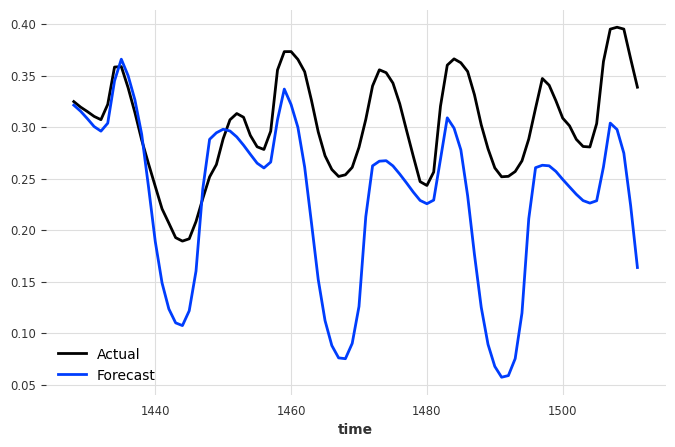

In [14]:
plt.figure(figsize=(8, 5))
test_actual_TimeSeries[1].plot(label="Actual")
pred_series[1].plot(label="Forecast")
plt.legend()

In [15]:
print(np.mean(mse(test_actual_TimeSeries,pred_series)), 
      np.mean(rmse(test_actual_TimeSeries,pred_series)),
        np.mean(mae(test_actual_TimeSeries,pred_series)),
        np.mean(smape(test_actual_TimeSeries,pred_series)), )
        # np.mean(mape(test_actual_TimeSeries,pred_series)))

0.011158015 0.09491058 0.07821378 31.490478004806597
